link to the overleaf project: https://www.overleaf.com/project/617a720c541e5437e1633b5a

# Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib notebook

import matplotlib
matplotlib.rc('font', size=14)
from matplotlib.gridspec import GridSpec

# Defining the ENSO class

$\dfrac{\text{d}T(t)}{\text{d}t}=T(t)-\alpha T(t-\delta)-T(t)^3$

In [2]:
class ENSO():
    def __init__(self,alpha, delta, t0s, T0s, find_by_guess=True):
        '''
        ----------
        Parameters:
            alpha:
            delta:
            t0s: list of time points for the initialization
                required condition: t0s[-1] - t0s[0] > delta
            T0s: list of temperature values at the time points in t0s
            
            find_by_guess: whether to find the correct time by guess (based on the timestep) or by search (default True)
        '''
        
        self.alpha = alpha
        self.delta = delta
        
        # time series of time and temperature
        self.ts = list(t0s)
        self.Ts = list(T0s)
        
        self.find_by_guess = find_by_guess
        
    def T(self,t):
        '''
        Compute temperature at any time t by a linear interpolation of the time series
        
        '''
        if t < self.ts[0] or t > self.ts[-1]:
            raise IndexError('Outside of interpolation range')
        if self.find_by_guess:
            local_dt = self.ts[-1] - self.ts[-2]
            nearest_previous_t_index = int(max(0, len(self.ts) + (t - self.ts[-1])//local_dt - 2))
            while True:
#                 print(nearest_previous_t_index)
                if self.ts[nearest_previous_t_index] < t:
                    if self.ts[nearest_previous_t_index + 1] >= t:
                        break
                    else:
                        nearest_previous_t_index += 1
#                         print('+1')
                else:
                    nearest_previous_t_index -= 1
#                     print('-1')
        
        else:
            nearest_previous_t_index = -1
            go_back_up_to = 1
            while nearest_previous_t_index == -1:
                go_back_up_to *= 10
                q = self.ts[-go_back_up_to:]
                nearest_previous_t_index = np.searchsorted(q,t) - 1

            nearest_previous_t_index = len(self.ts) - (len(q) - nearest_previous_t_index)
            
            
#         print(nearest_previous_t_index)
        
        t1 = self.ts[nearest_previous_t_index]
        T1 = self.Ts[nearest_previous_t_index]
        t2 = self.ts[nearest_previous_t_index + 1]
        T2 = self.Ts[nearest_previous_t_index + 1]
        
        return T1 + (t - t1)*(T2 - T1)/(t2 - t1)
    
    def __call__(self, t):
        '''
        Computes dT/dt at time t
        '''
        T = self.T(t)
        Td = self.T(t - self.delta)
        
        return T - self.alpha*Td - T**3
    
    
    def Euler(self, tmax, dt, show_progress_bar=True):
        '''
        Evolves the system with the Euler integration method (deterministic)
        
        $$
        dT = \\left( T(t)-\\alpha T(t-\\delta)-T(t)^3 \\right) dt
        $$
        
        -------
        Parameters:
            tmax: maximum t of the simulation
            dt: timestep
            show_progress_bar: wheteher to show a progress bar while the simulation is running (default True)
        '''
        new_points = np.arange(self.ts[-1], tmax, dt)
        
        for i in tqdm(range(1, len(new_points)), disable=not show_progress_bar):
            t_prev = new_points[i-1]
            T = self.T(t_prev)
            dT = self(t_prev)*dt
            
            new_t = new_points[i]
            new_T = T + dT
            
            self.ts.append(new_t)
            self.Ts.append(new_T)
    
    def Euler_Maruyama(self, tmax, dt, sigma, show_progress_bar=True):
        '''
        Evolves the system with the Euler-Maruyama integration method (stochastic)
        
        $$
        dT = \\left( T(t)-\\alpha T(t-\\delta)-T(t)^3 \\right) dt + \\sigma dW
        $$
        -------
        Parameters:
            tmax: maximum t of the simulation
            dt: timestep
            sigma: amplitude of the gaussian noise
            show_progress_bar: wheteher to show a progress bar while the simulation is running (default True)
        '''
        new_points = np.arange(self.ts[-1], tmax, dt)
        
        for i in tqdm(range(1, len(new_points)), disable=not show_progress_bar):
            t_prev = new_points[i-1]
            T = self.T(t_prev)
            dT = self(t_prev)*dt + sigma*np.sqrt(dt)*np.random.normal()
            
            new_t = new_points[i]
            new_T = T + dT
            
            self.ts.append(new_t)
            self.Ts.append(new_T)
    
    
    def plot(self, show_attractor=True, ax=None, label=None, figsize=(9,6)):
        '''
        Plots the time series and returns fig,ax
        
        ----------
        Parameters:
            show_attractor: whether to show the attractor in the limit delta -> 0 (default True)
            ax: axis on where to plot. If None (default) a new one is created
            label: label to put on the plot
            figsize: default (9,6)
        '''
        fig = None
        if ax is None:
            fig,ax = plt.subplots(figsize=figsize)
        ax.plot(self.ts, self.Ts, label=label)
        ax.set_xlabel('t')
        ax.set_ylabel('T')
        if label:
            plt.legend()

        if show_attractor:
            ax.set_xlim(*ax.get_xlim())
            
            if self.alpha < 1:
                ax.hlines([np.sqrt(1 - self.alpha), -np.sqrt(1 - self.alpha)],
                          *ax.get_xlim(), color='black', linestyle='dotted') 
            else:
                ax.hlines([0], *ax.get_xlim(), color='black', linestyle='dotted')
                
        if fig:
            fig.tight_layout()
        
        return fig,ax

# Testing

  0%|          | 0/99999 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


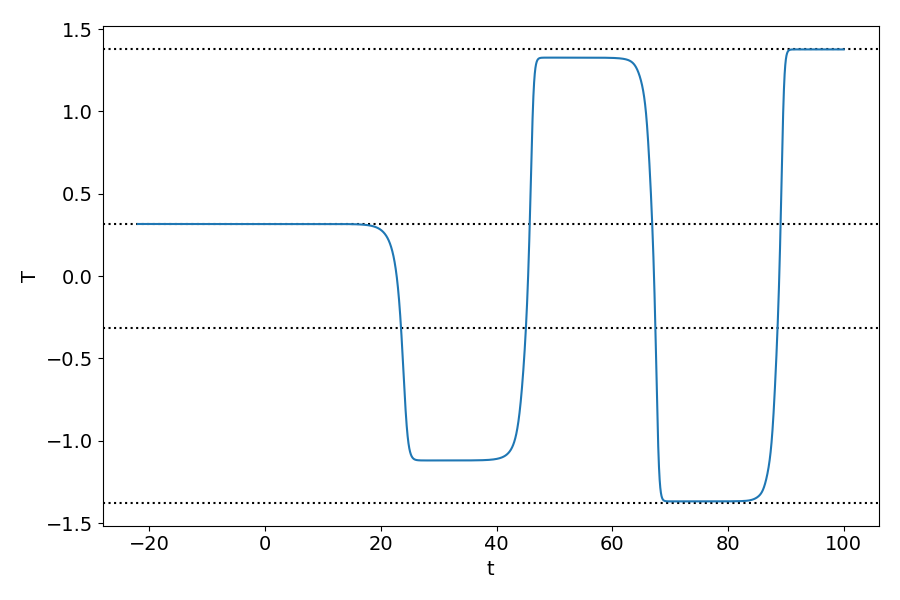

In [5]:
alpha = 0.9
delta = 20
epsilon = 1e-7
T0 = np.sqrt(1-alpha) + epsilon
# T0 = 0.1

e = ENSO(alpha=alpha, delta=delta,
         t0s=[-1.1*delta,0], T0s=[T0]*2,
#          t0s=np.linspace(-1.1*delta, 0, 100), T0s=np.random.uniform(-1,1, 100),
#          find_by_guess=False
        )

# e.Euler(tmax=20*delta, dt=0.1)
e.Euler(tmax=100, dt=0.001, show_progress_bar=True)
fig,ax = e.plot()

ax.hlines([np.sqrt(1 + alpha), -np.sqrt(1 + alpha)],
                          *ax.get_xlim(), color='black', linestyle='dotted') 

In [42]:
fig.savefig('delta1.230.pdf')

## Checking dependence on dt

<IPython.core.display.Javascript object>


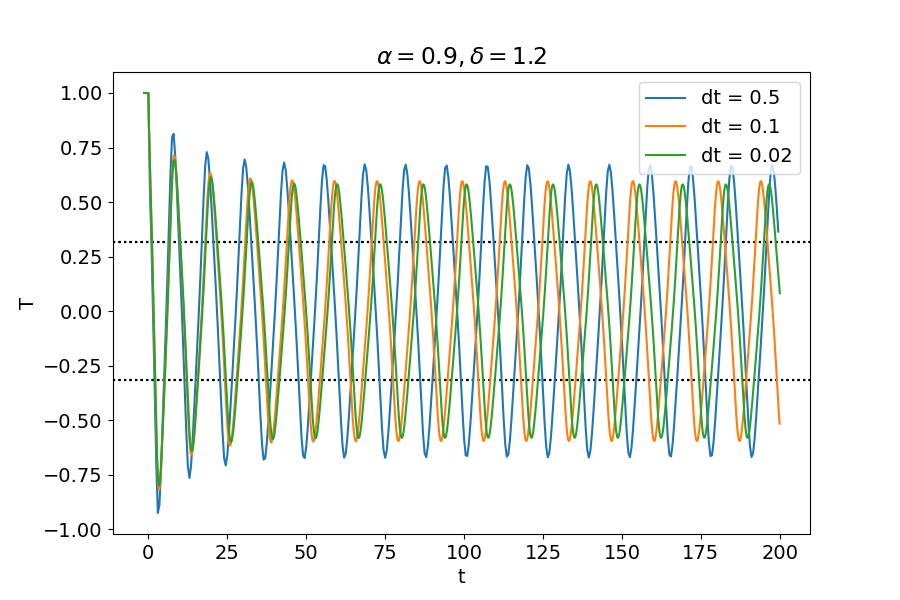

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

Text(0.5, 1.0, '$\\alpha=0.9, \\delta=1.2$')

In [195]:
alpha=0.9
delta = 1.2
tmax = 200
T0 = 1

dts = [5e-1, 1e-1, 2e-2]

fig,ax = plt.subplots(figsize=(9,6))

for dt in dts:
    e = ENSO(alpha=alpha, delta=delta,
             t0s=[-1.1*delta,0], T0s=[T0]*2,
            )
    e.Euler(tmax=tmax, dt=dt)
    
    e.plot(ax=ax, label=f'{dt = }')
    
plt.title(r'$\alpha=%.1f, \delta=%.1f$' %(alpha,delta))

In [196]:
fig.savefig('dt_dependence_supercritical.pdf')

# Critical delta

In [77]:
def delta_crit(alpha):
    if alpha < 1:
        return np.arccos((3*alpha - 2)/alpha)/np.sqrt(alpha**2 - (2 - 3*alpha)**2)
    elif alpha == 1:
        return 1.
    else:
        return np.arccos(1./alpha)/np.sqrt(alpha**2 - 1)

In [28]:
delta_crit(1.01)

0.993379659756883

<IPython.core.display.Javascript object>


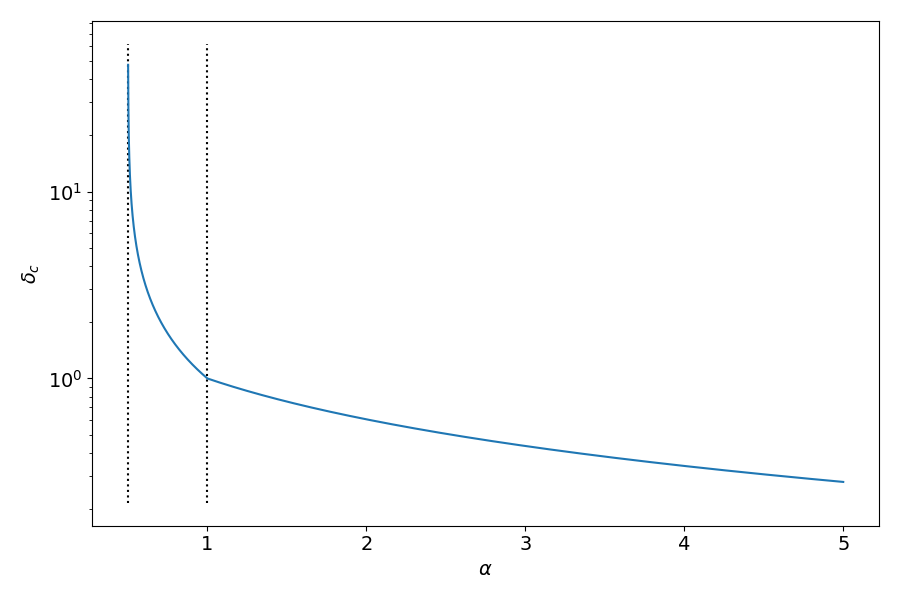

In [5]:
alphas = np.arange(0.501,5,0.0001)
delta_crits = [delta_crit(alpha) for alpha in alphas]

fig,ax = plt.subplots(figsize=(9,6))
plt.semilogy(alphas, delta_crits)

plt.vlines([0.5, 1], *ax.get_ylim(), color='black', linestyles='dotted')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta_{c}$')

fig.tight_layout()

In [6]:
fig.savefig('delta_crit_vs_alpha_extended.pdf')

## Defining the variance function

In [197]:
alpha = 0.9
epsilon = 1e-3
tmax = 500
dt = 0.01

T0 = np.sqrt(1-alpha) + epsilon

def var(delta):
    e = ENSO(alpha=0.9, delta=delta,
             t0s=[-1.1*delta,0], T0s=[T0]*2,
            )
    e.Euler(tmax=tmax, dt=dt, show_progress_bar=False)
    
    v = np.var(e.Ts)
    return v

## 1D variance plot

In [73]:
import adaptive
adaptive.notebook_extension()

In [198]:
learner = adaptive.Learner1D(var, bounds=[1,2])

In [199]:
runner = adaptive.Runner(learner, goal = lambda l: l.loss() < 0.01)
runner.live_info()

<IPython.core.display.Javascript object>


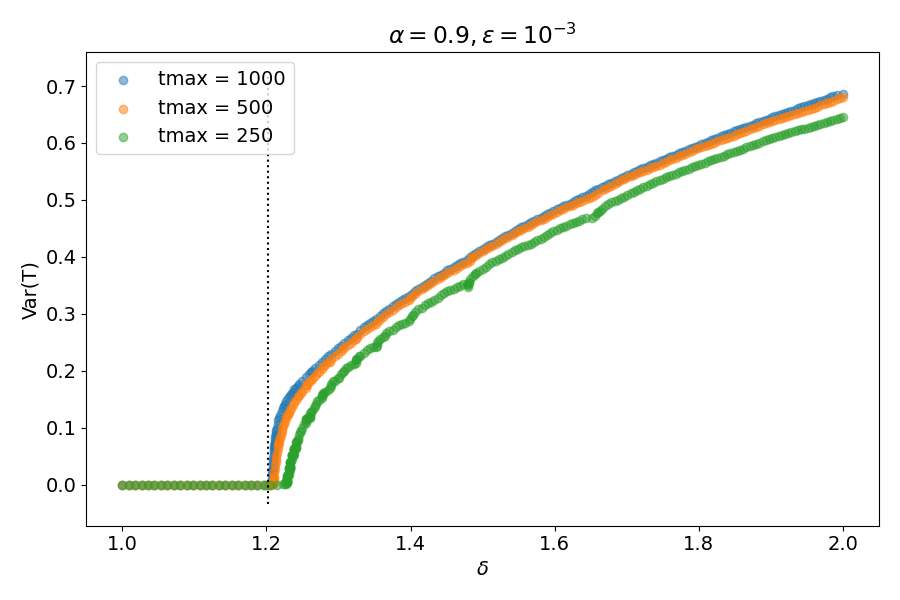

In [200]:
x = learner.data.keys()
y = learner.data.values()

x2 = learner2.data.keys()
y2 = learner2.data.values()

x3 = learner3.data.keys()
y3 = learner3.data.values()

fig,ax = plt.subplots(figsize=(9,6))
plt.scatter(x,y, alpha=0.5, label='tmax = 1000')
plt.scatter(x2,y2, alpha=0.5, label='tmax = 500')
plt.scatter(x3,y3, alpha=0.5, label='tmax = 250')
plt.title(r'$\alpha = %.1f, \epsilon = 10^{%d}$' %(alpha,np.log10(epsilon)))

# plt.scatter(x,y, alpha=0.5, label=r'$\epsilon = 10^{-5}$')
# plt.scatter(x2,y2, alpha=0.5, label=r'$\epsilon = 10^{-4}$')
# plt.scatter(x3,y3, alpha=0.5, label=r'$\epsilon = 10^{-3}$')
# plt.title(r'$\alpha = %.1f$, tmax = %d' %(alpha,tmax))


plt.xlabel(r'$\delta$')
plt.ylabel('Var(T)')

plt.vlines(delta_crit(alpha), *ax.get_ylim(), color='black', linestyles='dotted')

plt.legend()



fig.tight_layout()

In [165]:
fig.savefig('varT_vs_delta-varying_tmax.pdf')

## 2D variance plot

In [201]:
epsilon = 1e-3
def var2d(delta_alpha):
#     print(delta_alpha)
    delta, alpha = delta_alpha
    if alpha > 1:
        T0 = epsilon
    else:
        T0 = np.sqrt(1 - alpha) + epsilon
    e = ENSO(alpha=alpha, delta=delta,
       t0s=[-1.1*delta,0], T0s=[T0]*2,
      )
    e.Euler(tmax=1000, dt=0.02, show_progress_bar=False)
    
    v = np.var(e.Ts[-int(10000):])
    return v

In [202]:
learner = adaptive.Learner2D(var2d, bounds=[(0.1, 10), (0, 2)])

In [203]:
runner = adaptive.Runner(learner, goal = lambda l: l.loss() < 0.005)
runner.live_info()

In [7]:
learner.plot()

:Overlay
   .Image.I     :Image   [x,y]   (z)
   .EdgePaths.I :EdgePaths   [x,y]

In [204]:
xy = np.array(list(learner.data.keys()))
deltas, alphas = xy[:,0], xy[:,1]
vs = np.array(list(learner.data.values()))

In [81]:
var2d((0.5,0.5))

2.666673970537505e-05

<IPython.core.display.Javascript object>


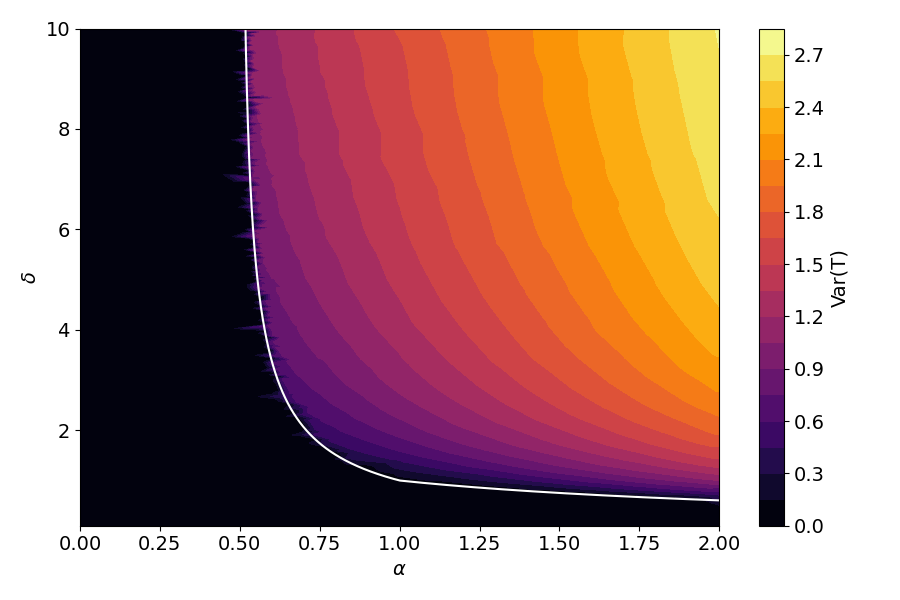

In [205]:
fig,ax = plt.subplots(figsize=(9,6))

plt.tricontourf(alphas, deltas, vs, cmap='inferno', levels=20)
plt.colorbar(label='Var(T)')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')

ax.set_xlim(*ax.get_xlim())
ax.set_ylim(*ax.get_ylim())

# plt.scatter(alphas, deltas)

alpha_s = np.arange(0.501,5,0.0001)
delta_crits = [delta_crit(alpha) for alpha in alpha_s]

plt.plot(alpha_s, delta_crits, color='white',
#          linestyle='dotted',
        )

fig.tight_layout()

In [206]:
fig.savefig('alpha_delta_contour_superimposed_dt0.02.pdf')

# Stochastic Dynamics

  0%|          | 0/499999 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


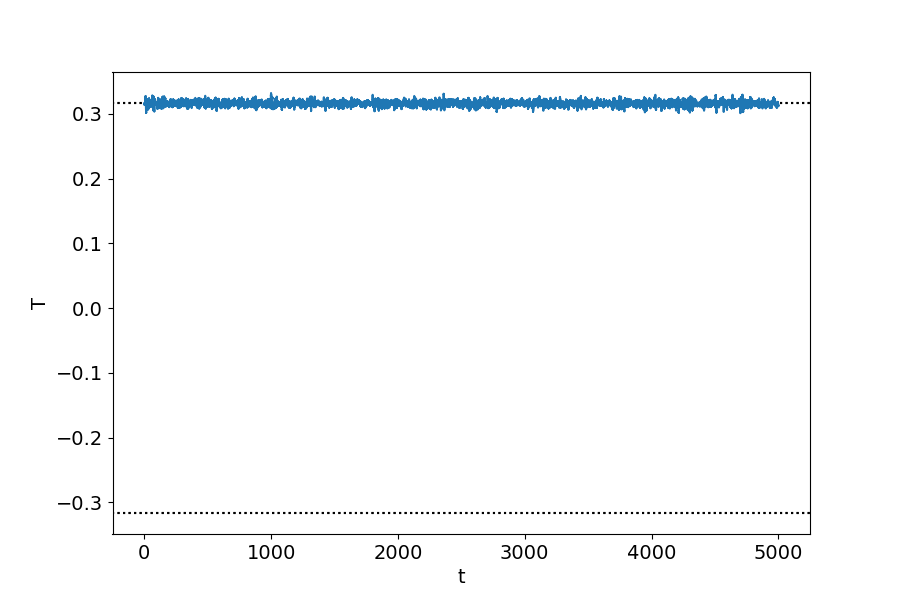

In [211]:
alpha = 0.9
delta = 1
epsilon = 0
T0 = np.sqrt(1-alpha) + epsilon
sigma = 1e-3

e = ENSO(alpha=alpha, delta=delta,
       t0s=[-1.1*delta,0], T0s=[T0]*2,
#        t0s=np.linspace(-1.1*delta, 0, 100), T0s=np.random.uniform(-1,1, 100),
      )

# e.Euler(tmax=20*delta, dt=0.1)
e.Euler_Maruyama(tmax=5000, dt=0.01, sigma=sigma)
fig,ax = e.plot()

ax.hlines([np.sqrt(1 - alpha), -np.sqrt(1 - alpha)], *ax.get_xlim(), color='black', linestyle='dotted')

In [235]:
matplotlib.rc('font', size=20)

In [275]:
alpha = 0.9
delta = 2
epsilon = 0
T0 = np.sqrt(1-alpha) + epsilon
sigma = 1e-5

e = ENSO(alpha=alpha, delta=delta,
       t0s=[-1.1*delta,0], T0s=[T0]*2,
#        t0s=np.linspace(-1.1*delta, 0, 100), T0s=np.random.uniform(-1,1, 100),
      )

# e.Euler(tmax=20*delta, dt=0.1)
e.Euler_Maruyama(tmax=10000, dt=0.02, sigma=sigma)

  0%|          | 0/499999 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


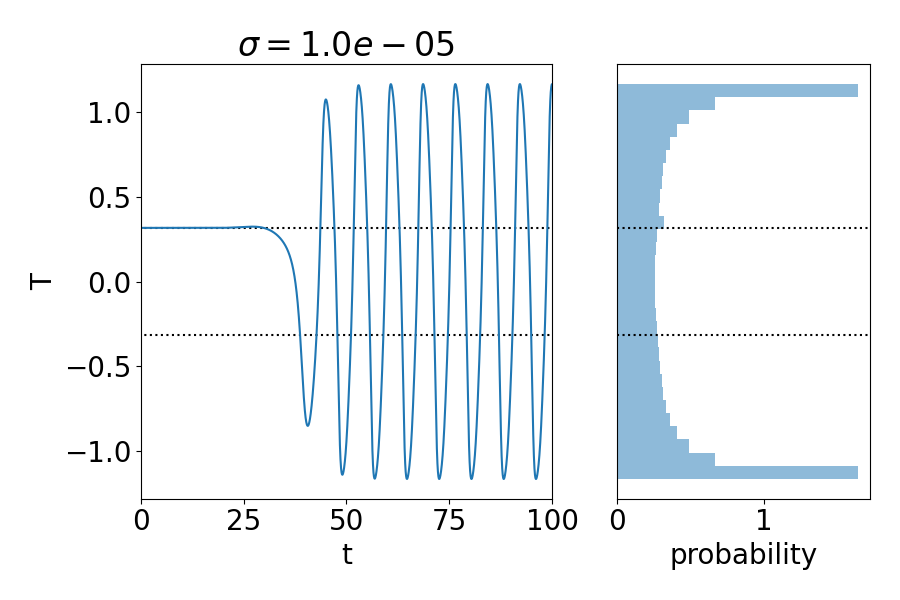

In [276]:
fig = plt.figure(figsize=(9,6))
gs = GridSpec(4,5)

ax_plot = fig.add_subplot(gs[:,0:3])
ax_hist = fig.add_subplot(gs[:,3:])

ax_plot.plot(np.array(e.ts), e.Ts)
ax_plot.set_xlim(ax_plot.get_xlim())
ax_plot.hlines([np.sqrt(1 - alpha), -np.sqrt(1 - alpha)], *ax_plot.get_xlim(), color='black', linestyle='dotted')

ax_hist.set_ylim(*ax_plot.get_ylim())
ax_hist.hist(e.Ts, bins=30, orientation='horizontal', alpha=0.5, density=True)
ax_hist.set_xlim(ax_hist.get_xlim())
ax_hist.hlines([np.sqrt(1 - alpha), -np.sqrt(1 - alpha)], *ax_hist.get_xlim(), color='black', linestyle='dotted')

ax_hist.get_yaxis().set_ticks([])

ax_plot.set_xlabel('t')
ax_plot.set_ylabel('T')
ax_hist.set_xlabel('probability')

ax_plot.set_xlim(0, 100)

ax_plot.set_title(r'$\sigma=%.1e$' %sigma)

fig.tight_layout()

In [267]:
fig.savefig('delta2_sigma%.4f.pdf' % sigma)

<IPython.core.display.Javascript object>


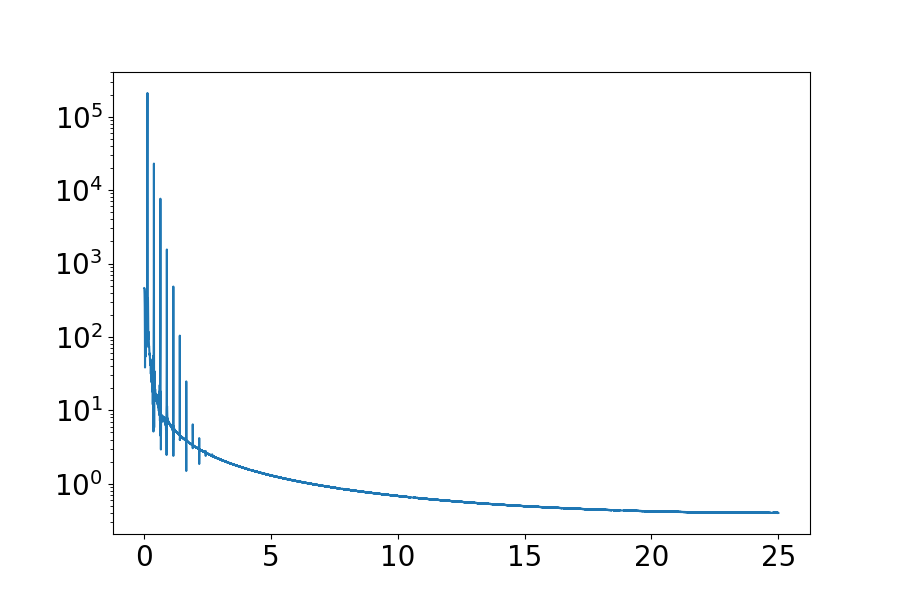

3.9177194354658784


In [279]:
fig,ax = plt.subplots(figsize=(9,6))

fft = np.fft.fft(e.Ts[100:])
freq = np.fft.fftfreq(len(e.ts[100:]), d=e.ts[-1]-e.ts[-2])

fft = fft[:len(fft)//2]
freq = freq[:len(freq)//2]

period = 1/(freq[np.argmax(np.abs(fft))])

print(period/delta)

plt.semilogy(freq, np.abs(fft))

# Fourier Analysis

In [284]:
matplotlib.rc('font', size=14)

  0%|          | 0/1599999 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


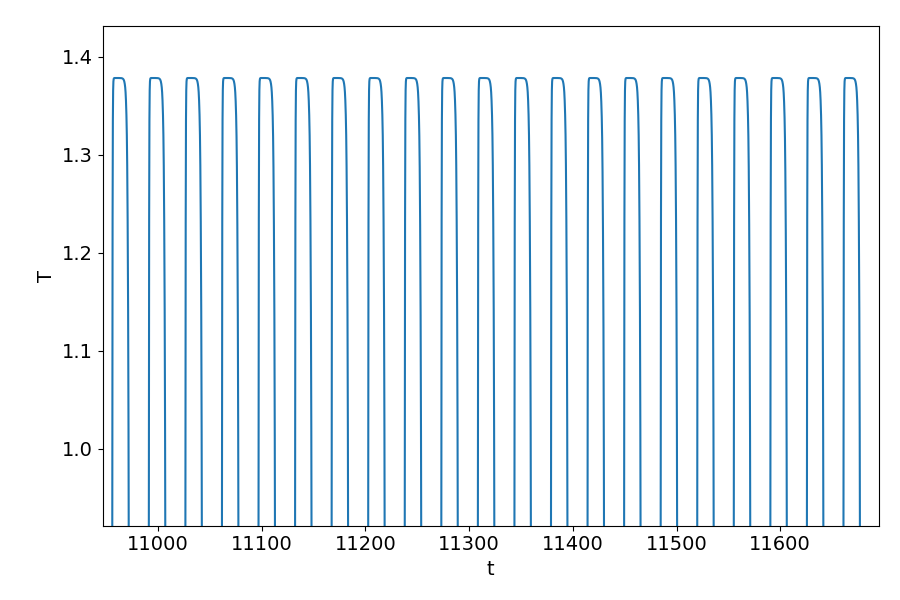

In [326]:
alpha = 0.9
delta = 16
epsilon = 1e-2
T0 = np.sqrt(1-alpha) + epsilon
# T0 = 0.1

e = ENSO(alpha=alpha, delta=delta,
         t0s=[-1.1*delta,0], T0s=[T0]*2,
#          t0s=np.linspace(-1.1*delta, 0, 100), T0s=np.random.uniform(-1,1, 100),
#          find_by_guess=False
        )

# e.Euler(tmax=20*delta, dt=0.1)
e.Euler(tmax=1000*delta, dt=0.01, show_progress_bar=True)
fig,ax = e.plot()

<IPython.core.display.Javascript object>


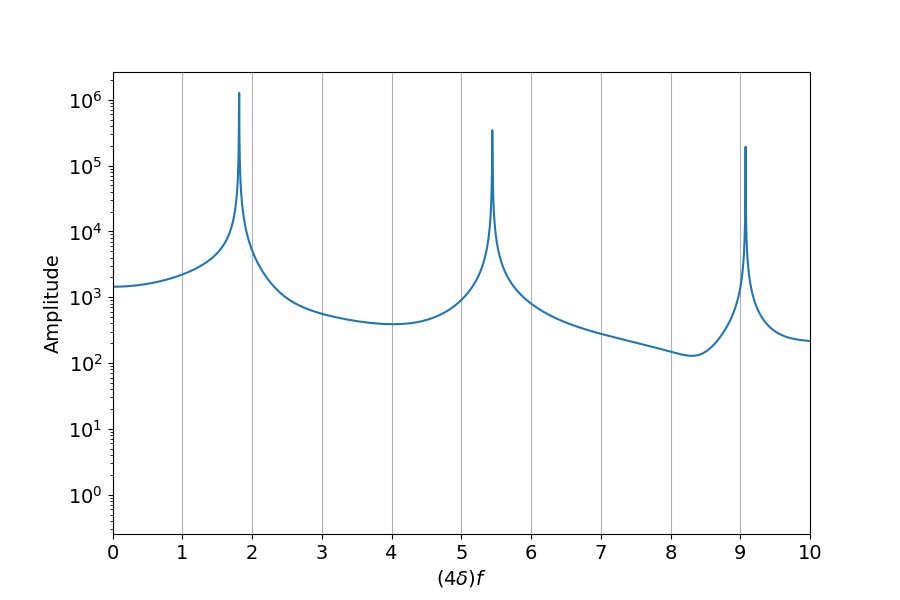

2.202506883307988


Text(0, 0.5, 'Amplitude')

In [327]:
fig,ax = plt.subplots(figsize=(9,6))

fft = np.fft.fft(e.Ts[100:])
freq = np.fft.fftfreq(len(e.ts[100:]), d=e.ts[-1]-e.ts[-2])

fft = fft[:len(fft)//2]
freq = freq[:len(freq)//2]

period = 1/(freq[np.argmax(np.abs(fft))])

print(period/delta)

plt.semilogy(freq*(4*delta), np.abs(fft))

ax.set_ylim(*ax.get_ylim())

# ax.vlines(np.arange(40)/(4*delta), *ax.get_ylim(), color='black', linestyle='dotted')

plt.xlim(0,10)
plt.xticks(np.arange(11))
plt.grid(axis='x')

plt.xlabel(r'$(4\delta) f$')
plt.ylabel('Amplitude')